In [1]:
import cupy as cp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import pickle
import sys


sys.path.append(os.path.join(os.getenv("HOME"), "gpuaffman_networks/"))
import general_network_visualization, memory_task_evolution, ragged_task_evolution, ragged_general_network
from genetics import analysis_util

In [2]:
data_dir = os.path.join(os.getenv("HOME"), "boolean_network_data/memory_evolution_results/2023-02-13-20-21-52")
best_error = np.load(os.path.join(data_dir, "best_errors.npy"))
with open(os.path.join(data_dir,"best_populations.pk"), "rb") as f:
    populations = pickle.load(f)


In [3]:
N = populations[0][0].shape[0]
input_state = cp.asnumpy(memory_task_evolution.make_memory_input_state(N))
batched_input_state = np.broadcast_to(np.expand_dims(np.expand_dims(input_state, 1), 1), (2, len(populations), 1, N)).astype(np.bool_)
best_functions = np.expand_dims(np.stack([x[0] for x in populations], axis=0), 1).astype(np.bool_)
best_conn = np.expand_dims(np.stack([x[1] for x in populations], axis=0), 1).astype(np.int16)
best_used_conn = np.expand_dims(np.stack([x[2] for x in populations], axis=0), 1).astype(np.bool_)

In [4]:
best_functions, best_conn, best_used_conn, sorted_perfs =  analysis_util.sort_by_performance(batched_input_state, best_functions, best_conn, best_used_conn, memory_task_evolution.evaluate_memory_task)

In [5]:
graphs = [general_network_visualization.influence_graph_from_ragged_spec(x[0], x[1], x[2]) for x in populations]

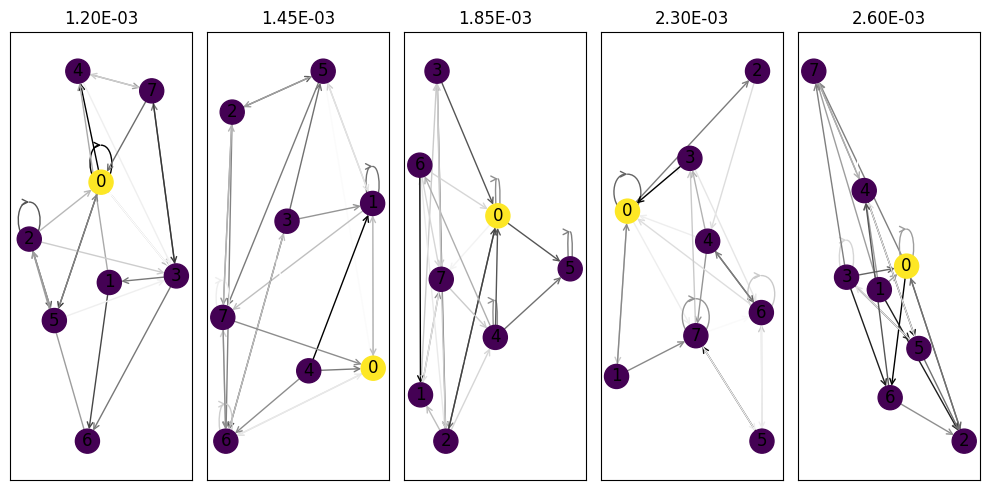

In [6]:
best_to_plot = 5
to_plot = graphs[:best_to_plot]
fig, axs = plt.subplots(ncols=len(to_plot), figsize=(10,5))
node_colors = np.zeros(N)
node_colors[0] = 1

for g, ax, err in zip(graphs, axs, sorted_perfs[:best_to_plot]):
    pos = nx.spring_layout(g, iterations=1000)
    general_network_visualization.plot_network_directed(g, pos, ax, node_colors)
    ax.set_title("{:.2E}".format(err))
fig.tight_layout()

In [7]:
example_trajs, example_noise = analysis_util.run_dynamics_forward_save_state(batched_input_state, best_functions, best_conn, best_used_conn, 20, 0.01)
example_trajs = np.squeeze(example_trajs, -2)
example_noise = np.squeeze(example_noise, -2)

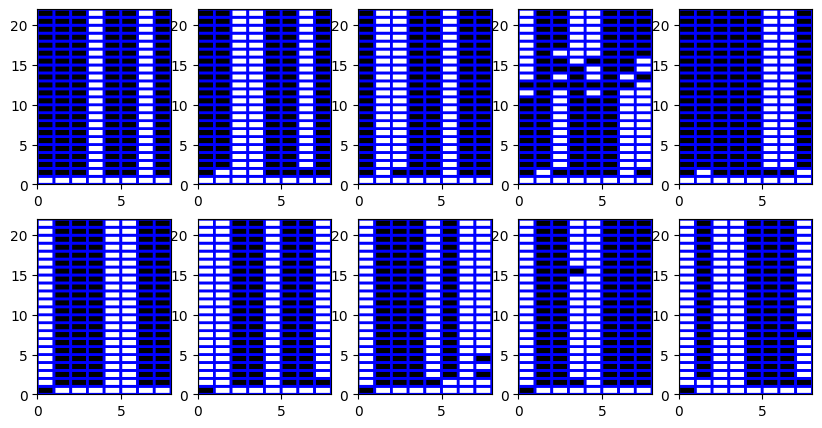

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=best_to_plot, figsize=(10, 5))
for i in range(best_to_plot):
    axs[0, i].pcolor(example_trajs[:, 0, i, :], cmap="Greys", linewidth=2, edgecolors="blue")
    axs[1, i].pcolor(example_trajs[:, 1, i, :], cmap="Greys", linewidth=2, edgecolors="blue")


In [9]:
physical_error_rates = np.linspace(start=0, stop=0.01, num=20)
logical_error_rates = analysis_util.generate_ft_curve(physical_error_rates, batched_input_state, best_functions, best_conn, best_used_conn, memory_task_evolution.evaluate_memory_task)

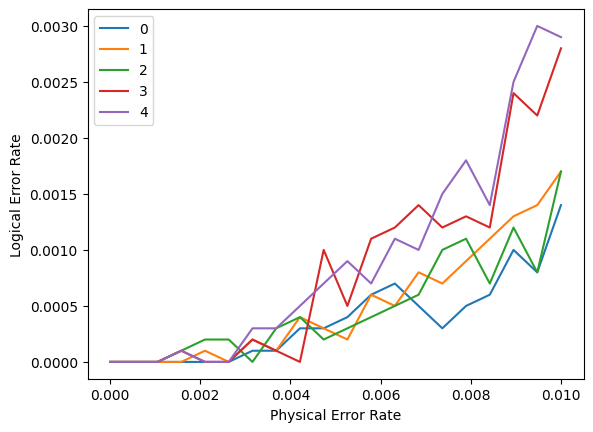

In [10]:
fig, axs = plt.subplots()
logical_error_rates = np.array(logical_error_rates)
for j in range(best_to_plot):
    axs.plot(physical_error_rates, logical_error_rates[:, j], label="{}".format(j))
axs.set_xlabel("Physical Error Rate")
axs.set_ylabel("Logical Error Rate")
axs.legend()


In [13]:
t_start = 5
t_end = 2000
all_death_probs = []
for error_rate in physical_error_rates:
    all_death_probs.append(analysis_util.death_prob_vs_time(cp.array(batched_input_state), cp.array(best_functions), cp.array(best_conn), cp.array(best_used_conn), 5000, error_rate, memory_task_evolution.evaluate_memory_task, t_start, t_end))
all_death_probs = cp.array(all_death_probs)


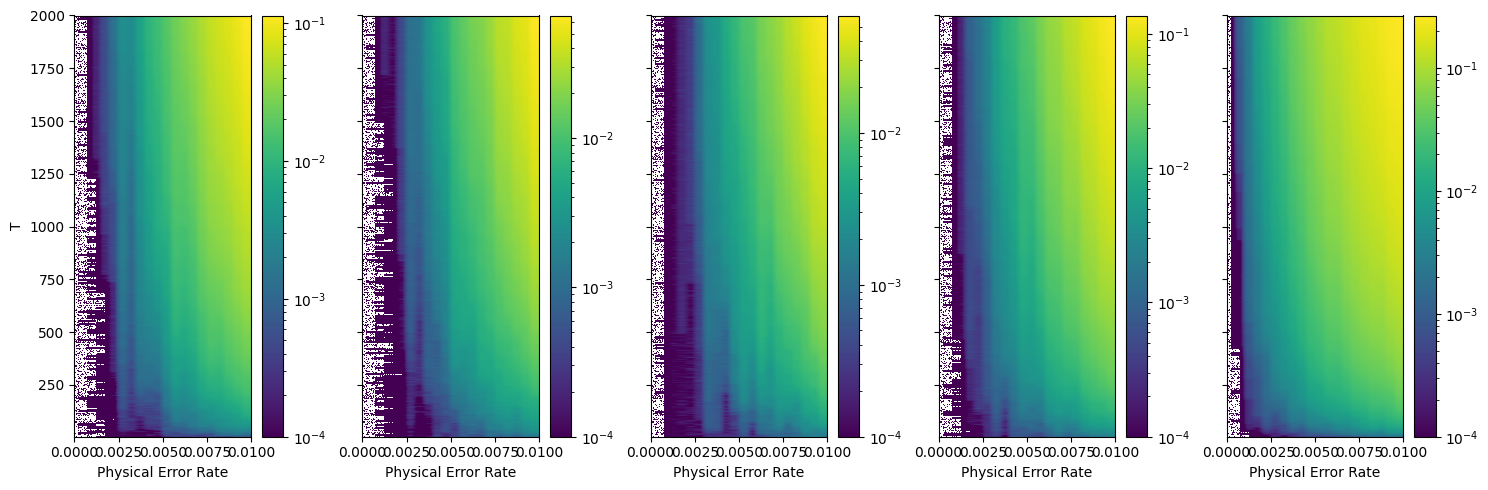

In [14]:
all_death_probs = cp.asnumpy(all_death_probs)
fig, axs = plt.subplots(nrows=1, ncols=best_to_plot, figsize=(15, 5), sharey=True)
for i, ax in enumerate(axs):
    im = ax.imshow(all_death_probs[:, :, i, 0].T, norm=matplotlib.colors.LogNorm(), extent=(physical_error_rates[0], physical_error_rates[-1], t_start, t_end ), origin="lower", aspect="auto")
    plt.colorbar(im)
    ax.set_xlabel("Physical Error Rate")
axs[0].set_ylabel("T")
fig.tight_layout()